In [1]:
from os import walk
from os.path import join
from typing import List, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# # Delete all zone identifier files
# import os
# for root, dirs, files in os.walk("./data"):
#     for name in files:
#         if name.endswith(":Zone.Identifier"):
#             os.remove(join(root, name))

In [3]:
def ingest_pid(pid_filename: str, traffic: bool, speed_limit: int, lr: bool):
    df: pd.DataFrame = pd.read_csv(pid_filename) # type: ignore
    # Drop the first row due to initialization movement.
    df.drop(index=df.index[0:5], axis=0, inplace=True) # type:ignore

    key_coords: List[float] = []
    coord_is_x: List[bool] = [False, False, False, True, True, True, True, False, False, False]
    use_gt: List[bool] = [True, True, True, True, True, True, True, True, True, True]

    # Progression order is dependent on lr variable.
    #   1. straight
    #   2. left or right
    #   3. straight
    #   4. right or left
    #   5. straight
    # Both start in the same place but start deviating at the 2nd intersection.

    # 1st int: straight
    # start: Lead Vehicle y axis value > -4374.36
    # end: Driver y axis value > -4205.00
    key_coords.append(-4374.36)
    key_coords.append(-4205.00)

    if lr:
        # straight, left, straight, right, straight
        use_gt[3:7] = [False, False, False, False]

        # 2nd int: left
        # start: Lead Vehicle y axis value > -1074.42
        # end: Driver x axis value < -2395.39
        key_coords.append(-1074.42)
        key_coords.append(-2395.39)

        # 3rd int: straight
        # start: Lead Vehicle x axis value < -5525.84
        # end: Driver x axis value < -5695.27
        key_coords.append(-5525.84)
        key_coords.append(-5695.27)

        # 4th int: right
        # start: Lead Vehicle x axis value < -8825.73
        # end: Driver y axis value > -904.95
        key_coords.append(-8825.73)
        key_coords.append(-904.95)

    else:
        # 2nd int: right
        # start: Lead Vehicle y axis value > -1074.42
        # end: Driver x axis value > -8825.60
        key_coords.append(-1074.42)
        key_coords.append(-8825.60)

        # 3rd int: straight
        # start: Lead Vehicle x axis value > -5695.27
        # end: Driver x axis value > -5525.84
        key_coords.append(-5695.27)
        key_coords.append(-5525.84)

        # 4th int: left
        # start: Lead Vehicle x axis value > -2395.00
        # end: Driver y axis value > -904.95
        key_coords.append(-2395.00)
        key_coords.append(-904.95)

    # 5th int: straight
    # start: Lead Vehicle y axis value > 2225.55
    # end: Driver y axis value > 2395.23
    key_coords.append(2225.55)
    key_coords.append(2395.23)
    
    assert len(key_coords) == len(coord_is_x) == 5*2
    assert len(key_coords)%2 == 0

    ok = 0
    lats_l = []
    lats_r = []
    lats_s = []
    throts_l = []
    throts_r = []
    throts_s = []

    # Gather intersection entrance and exit times for both vehicles
    for i in range(5):

        is_ok = False

        if i==1:
            move = 'L' if lr else 'R'
        elif i==3:
            move = 'R' if lr else 'L'
        else:
            move = str(i+1)

        i *= 2

        #         Lead Vehicle;     Driver
        # x axis: SCC_DynObj_Pos_0; VDS_Chassis_CG_Position_1
        # y axis: SCC_DynObj_Pos_1; VDS_Chassis_CG_Position_0
        if use_gt[i]:
            lead_enter_filter = df[f'SCC_DynObj_Pos_{int(not coord_is_x[i])}'] > key_coords[i]
            driver_enter_filter = df[f'VDS_Chassis_CG_Position_{int(coord_is_x[i])}'] > key_coords[i]
        else:
            lead_enter_filter = df[f'SCC_DynObj_Pos_{int(not coord_is_x[i])}'] < key_coords[i]
            driver_enter_filter = df[f'VDS_Chassis_CG_Position_{int(coord_is_x[i])}'] < key_coords[i]
        
        if use_gt[i+1]:
            lead_exit_filter = df[f'SCC_DynObj_Pos_{int(not coord_is_x[i+1])}'] > key_coords[i+1]
            driver_exit_filter = df[f'VDS_Chassis_CG_Position_{int(coord_is_x[i+1])}'] > key_coords[i+1]
        else:
            lead_exit_filter = df[f'SCC_DynObj_Pos_{int(not coord_is_x[i+1])}'] < key_coords[i+1]
            driver_exit_filter = df[f'VDS_Chassis_CG_Position_{int(coord_is_x[i+1])}'] < key_coords[i+1]


        try:
            # a is leader rows
            a = df[(df[lead_enter_filter]['timestamp'].iloc[0] <= df['timestamp']) &  # type: ignore
                (df['timestamp'] <= df[lead_exit_filter]['timestamp'].iloc[0])]  # type: ignore
            
            # b is driver rows
            b = df[(df[driver_enter_filter]['timestamp'].iloc[0] <= df['timestamp']) &  # type: ignore
                (df['timestamp'] <= df[driver_exit_filter]['timestamp'].iloc[0])]  # type: ignore
        except IndexError:
            print(f'IndexError: {move} {pid_filename}\n')
            continue

        if (a.shape[0] < 2) or (b.shape[0] < 2):  # type: ignore
            print(f'Too small: {move} {pid_filename}')
        elif (a.shape[0] > 1000) or (a.shape[0] > 1000):  # type: ignore
            print(f'Too large: {move} {pid_filename}')
        elif abs(a.shape[0]-b.shape[0]) > 100:  # type: ignore
            print(f'Large diff: {move} {pid_filename}')
        else:
            ok += 1
            is_ok = True

        if is_ok:

            # Make a and b the same length in timestamps
            n_shorter = min(a.shape[0], b.shape[0])
            a = a.iloc[:n_shorter, :]
            b = b.iloc[:n_shorter, :]

            heading = b['SCC_DynObj_Heading_0'].values

            # Find the difference vector from a to b, its magnitude, and angle
            x_delta = b['VDS_Chassis_CG_Position_1'].values - a['SCC_DynObj_Pos_0'].values
            y_delta = b['VDS_Chassis_CG_Position_0'].values - a['SCC_DynObj_Pos_1'].values
            mag_delta = (x_delta**2 + y_delta**2)**.5
            theta = np.arctan(y_delta/x_delta)

            # Project the difference vector onto the heading, with right of the heading vector being positive
            lat = np.sin(heading - theta) * mag_delta
            lat = lat[abs(lat).argmax()]
            thr = (np.cos(heading - theta) * mag_delta).tolist()
            
            if move == 'L':
                lats_l.append(lat)
                throts_l += thr
            elif move == 'R':
                lats_r.append(lat)
                throts_r += thr
            else:
                lats_s.append(lat)
                throts_s += thr

        else:
            print(df.shape, a.shape, b.shape)
            print([df[lead_enter_filter]['timestamp'].iloc[0], df[lead_exit_filter]['timestamp'].iloc[0]])
            print((df[driver_enter_filter]['timestamp'].iloc[0], df[driver_exit_filter]['timestamp'].iloc[0]))
            print('')

    return ok, lats_l, lats_r, lats_s, throts_l, throts_r, throts_s

ok = 0
count = 0
df_lat = pd.DataFrame(columns=['pid', 'move', 'traffic', 'speed_limit', 'lateral_max'])
df_thr = pd.DataFrame(columns=['pid', 'move', 'traffic', 'speed_limit', 'throttle_delta'])

for root, _, files in walk("./data"):
    for name in files:
        pid = int(root[-2:])
        if pid in {1, 2, 3, 4, 7}:
            continue
        if name.endswith(".csv"):
            # Check yes/no
            traffic = name[8:10] == "YE"
            try:
                speed_limit = int(name[10+traffic:12+traffic])
            except ValueError:
                # print('ERROR:', name)
                continue
            lr = name[13+traffic:15+traffic] == 'LR'
            try:
                oks, lat_l, lat_r, lat_s, throts_l, throts_r, throts_s = ingest_pid(join(root, name), traffic, speed_limit, lr)
                ok += oks
                df_lat = pd.concat([df_lat, pd.DataFrame({
                        'pid': pid,
                        'move': 'L',
                        'traffic': traffic,
                        'speed_limit': speed_limit,
                        'lateral_max': lat_l
                    })], ignore_index=True)
                df_lat = pd.concat([df_lat, pd.DataFrame({
                        'pid': pid,
                        'move': 'R',
                        'traffic': traffic,
                        'speed_limit': speed_limit,
                        'lateral_max': lat_r
                    })], ignore_index=True)
                df_lat = pd.concat([df_lat, pd.DataFrame({
                        'pid': pid,
                        'move': 'S',
                        'traffic': traffic,
                        'speed_limit': speed_limit,
                        'lateral_max': lat_s
                    })], ignore_index=True)
                df_thr = pd.concat([df_thr, pd.DataFrame({
                        'pid': pid,
                        'move': 'L',
                        'traffic': traffic,
                        'speed_limit': speed_limit,
                        'throttle_delta': throts_l
                    })], ignore_index=True)
                df_thr = pd.concat([df_thr, pd.DataFrame({
                        'pid': pid,
                        'move': 'R',
                        'traffic': traffic,
                        'speed_limit': speed_limit,
                        'throttle_delta': throts_r
                    })], ignore_index=True)
                df_thr = pd.concat([df_thr, pd.DataFrame({
                        'pid': pid,
                        'move': 'S',
                        'traffic': traffic,
                        'speed_limit': speed_limit,
                        'throttle_delta': throts_s
                    })], ignore_index=True)
                count += 5
            except IndexError:
                print('IndexError:', join(root, name))
                break

print(ok/count)

Large diff: 1 ./data/PID12/NSF_CPS_YES40_LR_20210517153936.daq.csv
(17136, 102) (433, 102) (177, 102)
['2021-05-17 15:40:14.941120', '2021-05-17 15:40:22.142560']
('2021-05-17 15:40:19.475360', '2021-05-17 15:40:22.409280')

Large diff: L ./data/PID12/NSF_CPS_YES40_LR_20210517153936.daq.csv
(17136, 102) (463, 102) (220, 102)
['2021-05-17 15:41:11.535770', '2021-05-17 15:41:19.237310']
('2021-05-17 15:41:15.603250', '2021-05-17 15:41:19.253980')

Large diff: 3 ./data/PID12/NSF_CPS_YES40_LR_20210517153936.daq.csv
(17136, 102) (317, 102) (202, 102)
['2021-05-17 15:42:10.547570', '2021-05-17 15:42:15.815290']
('2021-05-17 15:42:12.964720', '2021-05-17 15:42:16.315390')

Large diff: R ./data/PID12/NSF_CPS_YES40_LR_20210517153936.daq.csv
(17136, 102) (686, 102) (214, 102)
['2021-05-17 15:43:09.442680', '2021-05-17 15:43:20.861630']
('2021-05-17 15:43:14.443680', '2021-05-17 15:43:17.994390')

Large diff: 5 ./data/PID12/NSF_CPS_YES40_LR_20210517153936.daq.csv
(17136, 102) (524, 102) (173, 102

In [4]:
print(df_lat['pid'].unique().shape[0])

25


In [5]:
lats_grouped = df_lat.groupby(['move', 'traffic', 'speed_limit'])
lats_grouped.describe()

lateral_max                                   \
                               count       mean        std        min   
move traffic speed_limit                                                
L    False   30                 45.0   5.188426   9.642923 -17.197663   
             40                 43.0  -0.958145  11.157433 -24.443053   
     True    40                  3.0  -0.835797  40.498593 -47.505055   
R    False   30                 45.0   2.787212  10.210279 -18.729536   
             40                 46.0   3.490768  11.236070 -21.307830   
S    False   30                140.0   0.940633   2.243389 -11.046678   
             40                142.0   0.978277   1.760365  -3.092292   
     True    40                  1.0  68.756693        NaN  68.756693   

                                                                      
                                25%        50%        75%        max  
move traffic speed_limit                                              
L    False   30            1.819516   8.940623  11.062585  20.151261  
             40          -10.501531   3.567427   7.559835  18.969453  
     True    40          -13.789706  19.925644  22.498832  25.072019  
R    False   30           -5.517432   6.298179   9.132263  20.072842  
             40           -4.982308   6.128124  12.517558  21.376350  
S    False   30            0.542493   1.037732   1.588066  11.781614  
             40            0.387799   0.941541   1.711859  10.531243  
     True    40           68.756693  68.756693  68.756693  68.756693

In [11]:
throts_grouped = df_thr.groupby(['move', 'traffic', 'speed_limit'])
throts_grouped.describe()

throttle_delta                                   \
                                  count       mean        std        min   
move traffic speed_limit                                                   
L    False   30                 10549.0  -2.589813   8.084883 -33.547134   
             40                 10193.0  -4.187940  14.847331 -46.721989   
     True    40                   702.0   8.732834  15.650859 -13.185196   
R    False   30                  9939.0   1.170414   9.319726 -44.596252   
             40                  9750.0  -0.306477   9.873918 -33.186634   
S    False   30                 29797.0   1.400483  10.886117 -41.882712   
             40                 23604.0   0.039344   9.974089 -44.576951   
     True    40                   251.0 -22.515383  33.474938 -84.801219   

                                                                     
                                25%       50%        75%        max  
move traffic speed_limit                                             
L    False   30           -5.726824 -2.162812   0.061586  35.690972  
             40          -11.003391 -4.962918  -0.374094  45.508929  
     True    40           -3.418551  9.032593  15.664479  76.652710  
R    False   30           -3.075455  0.954362   6.458646  30.937175  
             40           -3.485224  0.668372   4.284650  38.570827  
S    False   30           -3.864881  0.975357   6.943454  47.109113  
             40           -3.906972 -0.157999   3.298167  63.700504  
     True    40          -55.040403 -4.050210   0.186977  67.673175

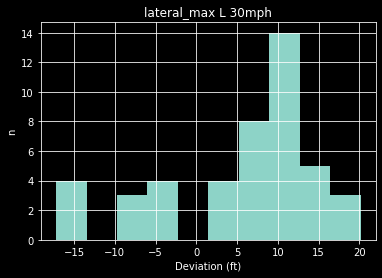

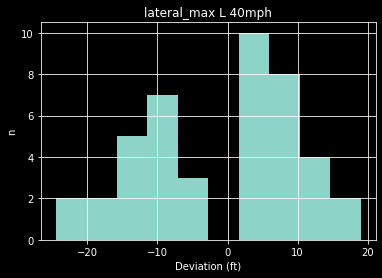

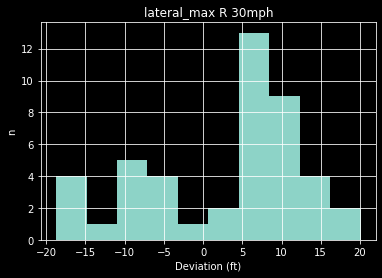

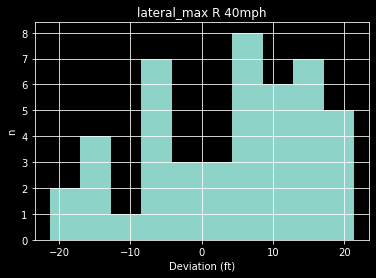

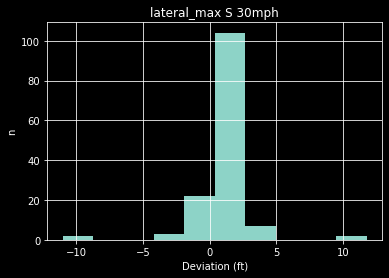

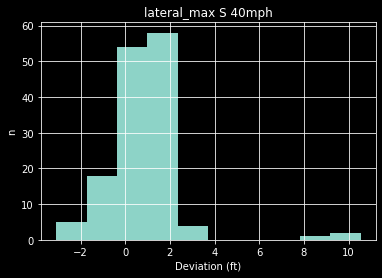

In [12]:
for group in lats_grouped.groups:
    if group[1]:
        continue
    lats_grouped.get_group(group).hist()
    title = f'lateral_max {group[0]} {group[2]}mph'
    plt.title(title)
    plt.ylabel('n')
    plt.xlabel('Deviation (ft)')
    plt.savefig(f'figs/{title}.png')
    plt.show()

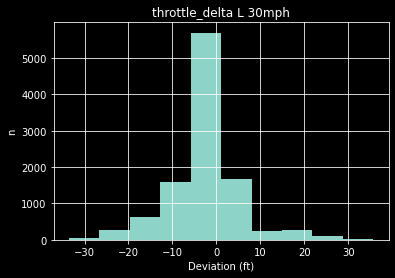

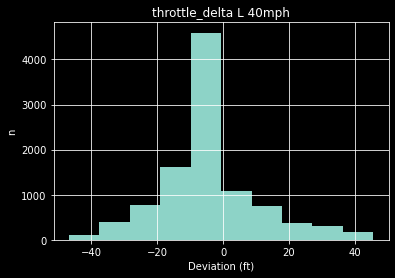

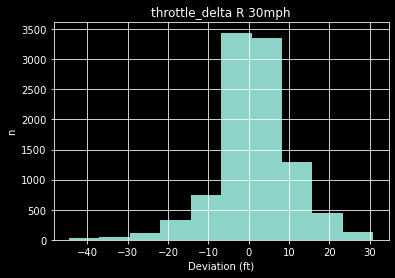

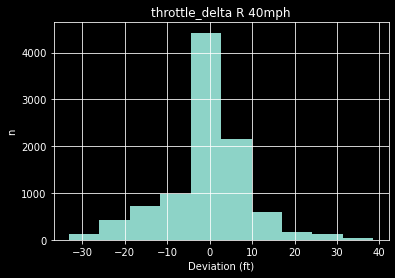

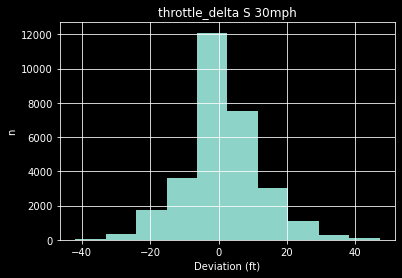

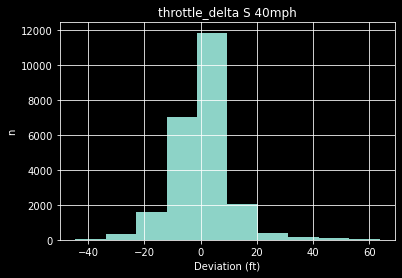

In [13]:
for group in throts_grouped.groups:
    if group[1]:
        continue
    throts_grouped.get_group(group).hist()
    title = f'throttle_delta {group[0]} {group[2]}mph'
    plt.title(title)
    plt.ylabel('n')
    plt.xlabel('Deviation (ft)')
    plt.savefig(f'figs/{title}.png')
    plt.show()